In [1]:
import numpy as np
import pandas as pd 
import scipy.stats as ss
from matplotlib import pyplot as plt
from random import randrange

from lifelines import WeibullFitter
import plotly.express as px

Lets make an asset with two failure modes

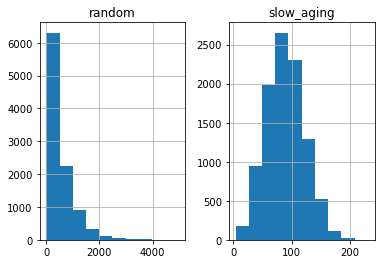

In [156]:
n_assets = 10000

slow_aging = dict(
    alpha = 100,
    beta = 3,
    gamma = 0,
)

random = dict(
    alpha = 500,
    beta = 1,
    gamma = 0,
)

failure_modes = dict(
    slow_aging = slow_aging,
    random = random,
)

failures = dict()

for fm_name, params in failure_modes.items():
    failures[fm_name] = ss.weibull_min.rvs(params['beta'], scale=params['alpha'], loc=params['gamma'], size=n_assets)
df = pd.DataFrame(failures)
df.hist();

Let's give every pole a random age beteween 0 and 100 years old and determine whether that pole is in service or has failed from one of our failure modes

In [157]:
min_age = 1
max_age = 100

df['in_service'] = [randrange(min_age, max_age) for n in range(n_assets)]

df['cause'] = df[list(failure_modes) + ['in_service']].T.idxmin()
df['age'] = df[list(failure_modes) + ['in_service']].min(axis=1)

df.head()

,slow_aging,random,in_service,cause,age
0,30.778009,756.759838,50,slow_aging,30.778009
1,58.729840,231.247880,74,slow_aging,58.729840
2,51.970338,360.675370,93,slow_aging,51.970338
3,118.415188,51.136668,16,in_service,16.000000
4,17.587327,1038.555254,12,in_service,12.000000


## Confirm WeibullFitter
Give the WeibullFitter all the failure data for each class to make sure that the class is working as expected.
We should see weibull parameters that closely match those that were used to setup the failure modes

In [158]:
wbf = WeibullFitter()
for cause in failure_modes:
    wbf.fit(durations=df[cause])

    print('%s - alpha %s - beta %s ' %(cause, wbf.lambda_, wbf.rho_))

slow_aging - alpha 99.99747484650555 - beta 3.001212595393392 
random - alpha 507.0696741547524 - beta 0.9987607002175458 


## Full History - Censoring
Let's check when fit a weibull using the age at failure for each cause as the duration and the censoring all other values

In [159]:

def fit_weibulls(data, causes):
    """ A simple function to fit the weibull data to our causes"""
    wbl_all_data = dict()

    durations = data['age']

    for cause in causes:
        event_observed = (data['cause'] == cause)
        wbf.fit(durations=durations, event_observed=event_observed)

        wbl_all_data[cause] = dict(
            alpha = wbf.lambda_,
            beta = wbf.rho_,
        )

    return wbl_all_data

# Check it works
fit_weibulls(df, list(failure_modes))

{'slow_aging': {'alpha': 100.63304946704443, 'beta': 2.954492172306198},
 'random': {'alpha': 485.9218805856052, 'beta': 1.0138492471206195}}

## Missing Data - Censoring
Now, we eliminate a percentage of the failures that occured within a certain age range and evaluate the impact that this has on the data we fit with the weibull

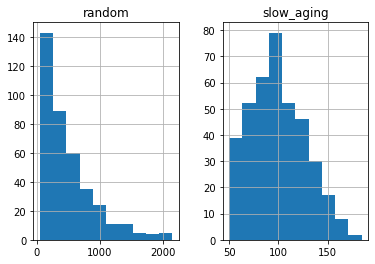

In [160]:

def sim_missing_data(df, min_age=0, max_age = 50, frac_lost=0.5):
    """ A function that deletes a percentage of data between the min and max ages"""
    missing_data = ((df['age'] > min_age) & (df['age'] < max_age))

    # Gget the data that isn't going to be lost
    df_not_lost = df.loc[~missing_data]

    # Add a sample of data that was lost based on the percentage
    df_with_missing = df_not_lost.append(df.loc[missing_data].sample(frac = (1 - frac_lost)))

    return df_with_missing

# Check the function works
df_with_missing = sim_missing_data(df, min_age=0, max_age = 50, frac_lost=1)
df_test[list(failure_modes)].hist();

In [161]:
fit_weibulls(df_with_missing, list(failure_modes))

{'slow_aging': {'alpha': 98.2062422209595, 'beta': 5.122878138023786},
 'random': {'alpha': 164.68501951189268, 'beta': 4.01800910465965}}

Let's put this together and see what impact missing data has on our esimates

In [169]:
d_frac_lost = np.linspace(0,1,11)

df_results = pd.DataFrame()

for frac_lost in d_frac_lost:
    
    # Remove a percent of the data
    df_with_missing = sim_missing_data(df, min_age=0, max_age = 50, frac_lost=frac_lost)

    # Fit a weibull to that data
    wbls = fit_weibulls(df_with_missing, list(failure_modes))

    # Record the results
    df_result = pd.DataFrame.from_dict(wbls, orient='index')
    df_result['frac_lost'] = frac_lost
    
    df_results = df_results.append(df_result)

df_results.index.name = 'cause'


In [176]:
px.line(df_results.reset_index(), x = 'frac_lost', y='alpha', color='cause', title = "Impact of missing data on Alpha")

In [177]:
px.line(df_results.reset_index(), x = 'frac_lost', y='beta', color='cause', title = "Impact of missing data on Beta")